In [75]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
# Load dataset
df = pd.read_csv('/content/7allV03.csv')

In [77]:
# Check the columns of the dataframe
print("Columns in the DataFrame:", df.columns)

Columns in the DataFrame: Index(['category', 'text'], dtype='object')


In [78]:
# Convert category to numerical labels
df['category'] = df['category'].astype('category')
df['label'] = df['category'].cat.codes

In [79]:
# Create a dictionary to map labels to category names
label_to_category = dict(enumerate(df['category'].cat.categories))
print("Label to Category Mapping:", label_to_category)

print("Updated Columns in the DataFrame:", df.columns)

Label to Category Mapping: {0: 'dunya ', 1: 'ekonomi ', 2: 'kultur ', 3: 'saglik ', 4: 'siyaset ', 5: 'spor ', 6: 'teknoloji '}
Updated Columns in the DataFrame: Index(['category', 'text', 'label'], dtype='object')


In [80]:
# Preprocess the dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [81]:
# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [82]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-uncased', num_labels=7)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
# Create data loaders
train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len=160)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len=160)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [84]:
# Fine-tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [85]:
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [86]:
def eval_model(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [87]:
EPOCHS = 5

train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    test_acc, test_loss = eval_model(model, test_loader, device)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)
    print(f'Test loss {test_loss} accuracy {test_acc}')

Epoch 1/5
Train loss 0.41924069742006914 accuracy 0.8767857142857144
Test loss 0.2841894214131659 accuracy 0.9153061224489797
Epoch 2/5
Train loss 0.1343307866429796 accuracy 0.9627551020408164
Test loss 0.22304755531912368 accuracy 0.9255102040816328
Epoch 3/5
Train loss 0.059249238029350434 accuracy 0.9864795918367348
Test loss 0.23609931756471914 accuracy 0.9295918367346939
Epoch 4/5
Train loss 0.033188812953553026 accuracy 0.992857142857143
Test loss 0.2426230947021395 accuracy 0.9265306122448981
Epoch 5/5
Train loss 0.025830774381756783 accuracy 0.9951530612244899
Test loss 0.2426230947021395 accuracy 0.9265306122448981


In [88]:
# Generate confusion matrix for train data
y_true_train = []
y_pred_train = []

In [89]:
model.eval()
with torch.no_grad():
    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

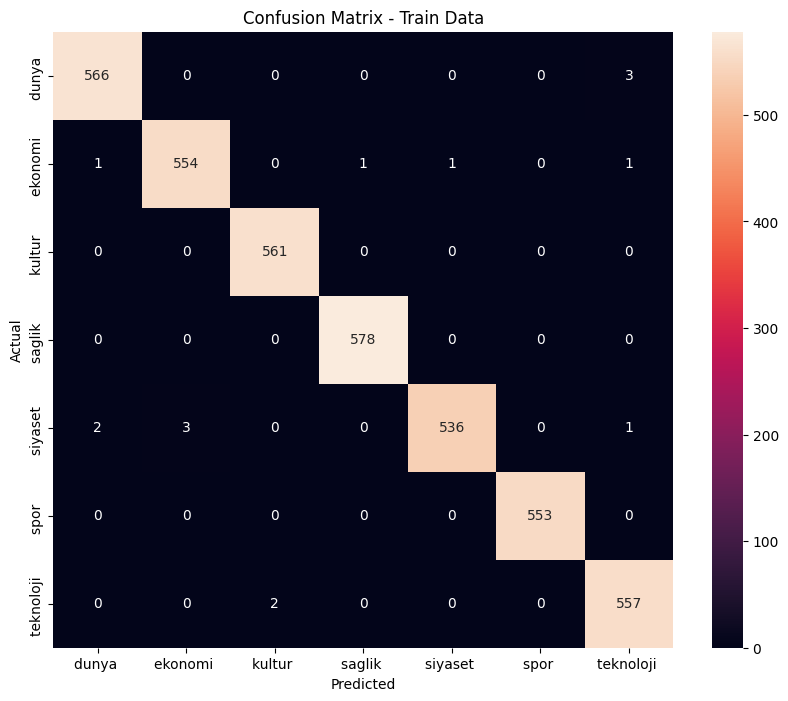

In [90]:
cm_train = confusion_matrix(y_true_train, y_pred_train)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=df['category'].cat.categories, yticklabels=df['category'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Data')
plt.show()

In [91]:
# Generate confusion matrix for test data
y_true_test = []
y_pred_test = []

In [92]:
model.eval()
with torch.no_grad():
    for data in test_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

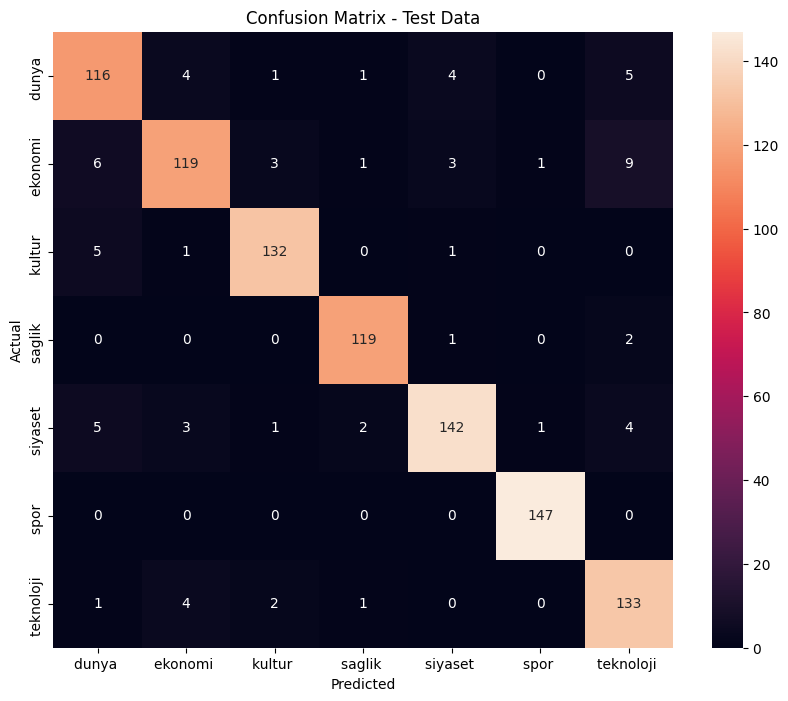

In [93]:
cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=df['category'].cat.categories, yticklabels=df['category'].cat.categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [94]:
# Make predictions
examples = [
    "maçın derve arasında teknik direktör oyuncuları daha baskılı oynamaları konusunda uyardı.",
    "uzmanlar dövizin daha da artacağını ve cari açığı finanse etmekte hükümetin zorlanacağını ve ek vergi talebinde bulunacağını tahmin ediyor.",
    "meclis grup toplantısında konuşan liderler, ülkenin birinci gündeminin artık seçimler için bir yol haritası çıkarmak olduğu konusunda anlaştılar.",
    "efes antik kentindeki tarihi eserlerin m.ö. 2000 yılına kadar uzandığına dair güçlü tarihi kalıntılar bulunmakta",
    "filipinlerde meydana gelen hanoi tayfunu binlerce kişiyi evlerinden etti, yerel kaynaklar son yüzyüzda bu şiddette bir felaketin yaşanmadığını bildirdi.",
    "orta yaş erkeklerde göbek yağlanması problemi, devamında kalp tansiyon gibi ciddi sağlık sorunlarını da beraberinde getirebiliyor, doktorlar bu konuda dikkat edilmesi tavsiyesinde bulundu.",
    "google ile microsoft arasındaki uygulama geliştrme rekabeti yeni bir hal aldı, artık google birçok yapay zeka uygulamasını ücretsiz vereceğini duyurdu."
]

In [95]:
model.eval()
with torch.no_grad():
    for example in examples:
        encoding = tokenizer.encode_plus(
            example,
            add_special_tokens=True,
            max_length=160,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        category = label_to_category[preds.cpu().numpy()[0]]
        print(f'Input: {example}')
        print(f'Prediction: {category}\n')

Input: maçın derve arasında teknik direktör oyuncuları daha baskılı oynamaları konusunda uyardı.
Prediction: spor 

Input: uzmanlar dövizin daha da artacağını ve cari açığı finanse etmekte hükümetin zorlanacağını ve ek vergi talebinde bulunacağını tahmin ediyor.
Prediction: ekonomi 

Input: meclis grup toplantısında konuşan liderler, ülkenin birinci gündeminin artık seçimler için bir yol haritası çıkarmak olduğu konusunda anlaştılar.
Prediction: dunya 

Input: efes antik kentindeki tarihi eserlerin m.ö. 2000 yılına kadar uzandığına dair güçlü tarihi kalıntılar bulunmakta
Prediction: kultur 

Input: filipinlerde meydana gelen hanoi tayfunu binlerce kişiyi evlerinden etti, yerel kaynaklar son yüzyüzda bu şiddette bir felaketin yaşanmadığını bildirdi.
Prediction: dunya 

Input: orta yaş erkeklerde göbek yağlanması problemi, devamında kalp tansiyon gibi ciddi sağlık sorunlarını da beraberinde getirebiliyor, doktorlar bu konuda dikkat edilmesi tavsiyesinde bulundu.
Prediction: saglik 

Inpu